In [42]:
import xgboost as xgb
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix, accuracy_score
import itertools as it

In [2]:
order_new = pd.read_csv("order_new.csv")
order_product_new = pd.read_csv("order_product_new.csv")


order_product_prior = pd.read_csv("order_product_prior.csv")
up_feature = pd.read_csv("up_feature.csv")
user_feature_1 = pd.read_csv("user_feature_1.csv")
user_feature_2 = pd.read_csv("user_feature_2.csv")

In [25]:
order_new

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,eval_set
0,2539329,1,1,2,8,NaN,Prior
1,2398795,1,2,3,7,15.0,Prior
2,473747,1,3,3,12,21.0,Prior
3,2254736,1,4,4,7,29.0,Prior
4,431534,1,5,4,15,28.0,Prior
...,...,...,...,...,...,...,...
3421078,2266710,206209,10,5,18,29.0,Prior
3421079,1854736,206209,11,4,10,30.0,Prior
3421080,626363,206209,12,1,12,18.0,Prior
3421081,2977660,206209,13,1,12,7.0,Prior


In [26]:
order_product_new

,order_id,product_id,add_to_cart_order,reorder
0,2,33120,1,0.0
1,2,28985,2,0.0
2,2,9327,3,0.0
3,2,45918,4,0.0
4,2,30035,5,0.0
...,...,...,...,...
33819101,3421063,14233,3,1.0
33819102,3421063,35548,4,1.0
33819103,3421070,35951,1,1.0
33819104,3421070,16953,2,1.0


In [7]:
order_product_new.product_id.nunique()

49685

In [27]:
# join orders_new and order_product_new together
join = pd.merge(order_product_new, order_new, on = 'order_id', how = 'left' )
join

,order_id,product_id,add_to_cart_order,reorder,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,eval_set
0,2,33120,1,0.0,202279,3,5,9,8.0,Prior
1,2,28985,2,0.0,202279,3,5,9,8.0,Prior
2,2,9327,3,0.0,202279,3,5,9,8.0,Prior
3,2,45918,4,0.0,202279,3,5,9,8.0,Prior
4,2,30035,5,0.0,202279,3,5,9,8.0,Prior
...,...,...,...,...,...,...,...,...,...,...
33819101,3421063,14233,3,1.0,169679,30,0,10,4.0,Train
33819102,3421063,35548,4,1.0,169679,30,0,10,4.0,Train
33819103,3421070,35951,1,1.0,139822,15,6,10,8.0,Train
33819104,3421070,16953,2,1.0,139822,15,6,10,8.0,Train


In [28]:
order_product_prior = join[join['eval_set'] == 'Prior']
order_product_prior.shape

(32434489, 10)

In [29]:
order_product_prior.head()

,order_id,product_id,add_to_cart_order,reorder,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,eval_set
0,2,33120,1,0.0,202279,3,5,9,8.0,Prior
1,2,28985,2,0.0,202279,3,5,9,8.0,Prior
2,2,9327,3,0.0,202279,3,5,9,8.0,Prior
3,2,45918,4,0.0,202279,3,5,9,8.0,Prior
4,2,30035,5,0.0,202279,3,5,9,8.0,Prior


In [12]:
order_product_prior.to_csv('order_product_prior.csv',index=False)

In [30]:
# Based on table orders_new, for each user, calculate the max order_number, the sum of 
#days_since_prior_order and the average of days_since_prior_order. 
df1 = order_new[order_new['eval_set'] == 'Prior']

user_id = df1['user_id'].unique()
user_orders = df1.groupby(['user_id'])['order_number'].max()
sum_days_since_prior_order = df1.groupby(['user_id'])['days_since_prior_order'].sum()
avg_days_since_prior_order = df1.groupby(['user_id'])['days_since_prior_order'].mean()

In [31]:
user_feature_1 = pd.DataFrame({
    'user_orders': user_orders,
    'sum_days_since_prior_order': sum_days_since_prior_order,
    'avg_days_since_prior_order': avg_days_since_prior_order
})
user_feature_1 = user_feature_1.reset_index()
user_feature_1.head(10)

,user_id,user_orders,sum_days_since_prior_order,avg_days_since_prior_order
0,1,10,176.0,19.555556
1,2,14,198.0,15.230769
2,3,12,133.0,12.090909
3,4,5,55.0,13.750000
4,5,4,40.0,13.333333
5,6,3,18.0,9.000000
6,7,20,203.0,10.684211
7,8,3,60.0,30.000000
8,9,3,36.0,18.000000
9,10,5,79.0,19.750000


In [16]:
user_feature_1.to_csv('user_feature_1.csv',index=False)

In [32]:
#for each user calculate the total number of products, total number of distinct products, 
#and user reorder ratio(number of reordered = 1 divided by number of order_number > 1)
df = order_product_prior[order_product_prior['order_number'] > 1]

total_products = order_product_prior.groupby('user_id')['product_id'].count()
distinct_products = order_product_prior.groupby('user_id')['product_id'].nunique()
reordered_sum = order_product_prior.groupby('user_id')['reorder'].sum()
reordered_count = df.groupby('user_id')['reorder'].count()

In [33]:
df

,order_id,product_id,add_to_cart_order,reorder,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,eval_set
0,2,33120,1,0.0,202279,3,5,9,8.0,Prior
1,2,28985,2,0.0,202279,3,5,9,8.0,Prior
2,2,9327,3,0.0,202279,3,5,9,8.0,Prior
3,2,45918,4,0.0,202279,3,5,9,8.0,Prior
4,2,30035,5,0.0,202279,3,5,9,8.0,Prior
...,...,...,...,...,...,...,...,...,...,...
32434484,3421083,39678,6,1.0,25247,24,2,6,21.0,Prior
32434485,3421083,11352,7,1.0,25247,24,2,6,21.0,Prior
32434486,3421083,4600,8,1.0,25247,24,2,6,21.0,Prior
32434487,3421083,24852,9,1.0,25247,24,2,6,21.0,Prior


In [34]:
user_feature_2 = pd.DataFrame({
    'total_products': total_products,
    'distinct_products': distinct_products,
    'reordered_ratio': reordered_sum/reordered_count
})
user_feature_2.head(10)

,total_products,distinct_products,reordered_ratio
user_id,,,
1,59,18,0.759259
2,195,102,0.576923
3,88,33,0.666667
4,18,17,0.642857
5,37,23,0.961538
6,14,12,0.400000
7,206,68,0.680412
8,49,36,1.000000
9,76,58,1.000000


In [19]:
user_feature_2.to_csv('user_feature_2.csv',index=False)

In [35]:
#for each user and product, calculate the total number of orders, minimum order_number,
#maximum order_number and average add_to_cart_order.
m = order_product_prior.groupby(['user_id','product_id'])

In [36]:
up_feature = pd.DataFrame({
    'up_orders': m['order_number'].count(),
    'up_first_order': m['order_number'].min(),
    'up_last_order': m['order_number'].max(),
    'up_average_cart_position': m['add_to_cart_order'].mean()
})

In [37]:
up_feature = up_feature.reset_index()
up_feature.head(10)

,user_id,product_id,up_orders,up_first_order,up_last_order,up_average_cart_position
0,1,196,10,1,10,1.400000
1,1,10258,9,2,10,3.333333
2,1,10326,1,5,5,5.000000
3,1,12427,10,1,10,3.300000
4,1,13032,3,2,10,6.333333
5,1,13176,2,2,5,6.000000
6,1,14084,1,1,1,2.000000
7,1,17122,1,5,5,6.000000
8,1,25133,8,3,10,4.000000
9,1,26088,2,1,2,4.500000


In [23]:
up_feature.to_csv('up_feature.csv',index=False)

In [38]:
#calculate the sequence of product purchase for each user (e.g. if a user bought egg product 
#in the first oder and second order, the value should be 1 and 2 respectively) and name it 
#product_seq_time.
order_product_prior['product_seq_time'] = order_product_prior.groupby(['user_id','product_id'])['order_number'].rank()



/Users/apple/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [39]:
m = order_product_prior.groupby('product_id')

In [40]:
#for each product,  calculate the count, sum of reordered, count of product_seq_time = 1
#(hint: Sum(CASE WHEN product_seq_time = 1 THEN 1 ELSE 0 END)) and count of product_seq_time = 2.
prd_feature = pd.DataFrame({
    'prod_orders': m['order_number'].count(),
    'prod_reorders': m['reorder'].sum(),
    'prod_first_orders': order_product_prior[order_product_prior['product_seq_time'] == 1].groupby('product_id')['product_seq_time'].sum(),
    'prod_second_orders': order_product_prior[order_product_prior['product_seq_time'] == 2].groupby('product_id')['product_seq_time'].count()
})

In [41]:
prd_feature = prd_feature.reset_index()
prd_feature.head(10)

,product_id,prod_orders,prod_reorders,prod_first_orders,prod_second_orders
0,1,1852,1066.0,716.0,276.0
1,2,90,51.0,78.0,8.0
2,3,277,167.0,74.0,36.0
3,4,329,192.0,182.0,64.0
4,5,15,8.0,6.0,4.0
5,6,8,3.0,5.0,2.0
6,7,30,22.0,18.0,6.0
7,8,165,88.0,82.0,30.0
8,9,156,91.0,74.0,31.0
9,10,2572,1481.0,1268.0,399.0


In [8]:
prd_feature.to_csv('prd_feature.csv',index=False)

In [43]:
data = pd.merge(user_feature_1, user_feature_2, on = 'user_id', how = 'left')
data = pd.merge(data, up_feature, on = 'user_id', how = 'left')
data = pd.merge(data, prd_feature, on = 'product_id', how = 'left')

In [44]:
data.head(10)

,user_id,user_orders,sum_days_since_prior_order,avg_days_since_prior_order,total_products,distinct_products,reordered_ratio,product_id,up_orders,up_first_order,up_last_order,up_average_cart_position,prod_orders,prod_reorders,prod_first_orders,prod_second_orders
0,1,10,176.0,19.555556,59,18,0.759259,196,10,1,10,1.400000,35791,20502.0,8000.0,4660.0
1,1,10,176.0,19.555556,59,18,0.759259,10258,9,2,10,3.333333,1946,1092.0,557.0,308.0
2,1,10,176.0,19.555556,59,18,0.759259,10326,1,5,5,5.000000,5526,3114.0,1923.0,1003.0
3,1,10,176.0,19.555556,59,18,0.759259,12427,10,1,10,3.300000,6476,3662.0,1679.0,889.0
4,1,10,176.0,19.555556,59,18,0.759259,13032,3,2,10,6.333333,3751,2149.0,1286.0,617.0
5,1,10,176.0,19.555556,59,18,0.759259,13176,2,2,5,6.000000,379450,217064.0,63537.0,45231.0
6,1,10,176.0,19.555556,59,18,0.759259,14084,1,1,1,2.000000,15935,9029.0,3012.0,1895.0
7,1,10,176.0,19.555556,59,18,0.759259,17122,1,5,5,6.000000,13880,8097.0,4503.0,2375.0
8,1,10,176.0,19.555556,59,18,0.759259,25133,8,3,10,4.000000,6196,3509.0,1610.0,935.0
9,1,10,176.0,19.555556,59,18,0.759259,26088,2,1,2,4.500000,2523,1417.0,1163.0,471.0


In [45]:
data['prod_reorder_probability'] = data.prod_second_orders / data.prod_first_orders
data['prod_reorder_times'] = 1 + data.prod_reorders / data.prod_first_orders
data['prod_reorder_ratio'] = data.prod_reorders / data.prod_orders
data.drop(['prod_reorders', 'prod_first_orders', 'prod_second_orders'], axis=1, inplace=True)
data['user_average_basket'] = data.total_products / data.user_orders
data['up_order_rate'] = data.up_orders / data.user_orders
data['up_orders_since_last_order'] = data.user_orders - data.up_last_order
data['up_order_rate_since_first_order'] = data.up_orders / (data.user_orders - data.up_first_order + 1)

In [46]:
prd = data['product_id']
data.drop(labels=['product_id'], axis=1,inplace = True)
data.insert(1, 'product_id', prd)
data.head(10)

,user_id,product_id,user_orders,sum_days_since_prior_order,avg_days_since_prior_order,total_products,distinct_products,reordered_ratio,up_orders,up_first_order,up_last_order,up_average_cart_position,prod_orders,prod_reorder_probability,prod_reorder_times,prod_reorder_ratio,user_average_basket,up_order_rate,up_orders_since_last_order,up_order_rate_since_first_order
0,1,196,10,176.0,19.555556,59,18,0.759259,10,1,10,1.400000,35791,0.582500,3.562750,0.572826,5.9,1.0,0,1.000000
1,1,10258,10,176.0,19.555556,59,18,0.759259,9,2,10,3.333333,1946,0.552962,2.960503,0.561151,5.9,0.9,0,1.000000
2,1,10326,10,176.0,19.555556,59,18,0.759259,1,5,5,5.000000,5526,0.521581,2.619345,0.563518,5.9,0.1,5,0.166667
3,1,12427,10,176.0,19.555556,59,18,0.759259,10,1,10,3.300000,6476,0.529482,3.181060,0.565473,5.9,1.0,0,1.000000
4,1,13032,10,176.0,19.555556,59,18,0.759259,3,2,10,6.333333,3751,0.479782,2.671073,0.572914,5.9,0.3,0,0.333333
5,1,13176,10,176.0,19.555556,59,18,0.759259,2,2,5,6.000000,379450,0.711884,4.416340,0.572049,5.9,0.2,5,0.222222
6,1,14084,10,176.0,19.555556,59,18,0.759259,1,1,1,2.000000,15935,0.629150,3.997676,0.566614,5.9,0.1,9,0.100000
7,1,17122,10,176.0,19.555556,59,18,0.759259,1,5,5,6.000000,13880,0.527426,2.798135,0.583357,5.9,0.1,5,0.166667
8,1,25133,10,176.0,19.555556,59,18,0.759259,8,3,10,4.000000,6196,0.580745,3.179503,0.566333,5.9,0.8,0,1.000000
9,1,26088,10,176.0,19.555556,59,18,0.759259,2,1,2,4.500000,2523,0.404987,2.218401,0.561633,5.9,0.2,8,0.200000


In [47]:
data.to_csv('data.csv',index=False)

In [3]:
data = pd.read_csv("data.csv")
data

,user_id,product_id,user_orders,sum_days_since_prior_order,avg_days_since_prior_order,total_products,distinct_products,reordered_ratio,up_orders,up_first_order,up_last_order,up_average_cart_position,prod_orders,prod_reorder_probability,prod_reorder_times,prod_reorder_ratio,user_average_basket,up_order_rate,up_orders_since_last_order,up_order_rate_since_first_order
0,1,196,10,176.0,19.555556,59,18,0.759259,10,1,10,1.400000,35791,0.582500,3.562750,0.572826,5.900000,1.000000,0,1.000000
1,1,10258,10,176.0,19.555556,59,18,0.759259,9,2,10,3.333333,1946,0.552962,2.960503,0.561151,5.900000,0.900000,0,1.000000
2,1,10326,10,176.0,19.555556,59,18,0.759259,1,5,5,5.000000,5526,0.521581,2.619345,0.563518,5.900000,0.100000,5,0.166667
3,1,12427,10,176.0,19.555556,59,18,0.759259,10,1,10,3.300000,6476,0.529482,3.181060,0.565473,5.900000,1.000000,0,1.000000
4,1,13032,10,176.0,19.555556,59,18,0.759259,3,2,10,6.333333,3751,0.479782,2.671073,0.572914,5.900000,0.300000,0,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13307948,206209,43961,13,210.0,17.500000,129,68,0.715517,3,4,12,8.000000,55371,0.514642,2.552628,0.573567,9.923077,0.230769,1,0.300000
13307949,206209,44325,13,210.0,17.500000,129,68,0.715517,1,7,7,8.000000,3485,0.289890,1.931960,0.558106,9.923077,0.076923,6,0.142857
13307950,206209,48370,13,210.0,17.500000,129,68,0.715517,1,11,11,8.000000,3934,0.592561,2.900254,0.571429,9.923077,0.076923,2,0.333333
13307951,206209,48697,13,210.0,17.500000,129,68,0.715517,1,7,7,6.000000,9783,0.260662,1.874443,0.561689,9.923077,0.076923,6,0.142857


In [4]:
order_new_s = order_new[['user_id','eval_set']]
order_new_s.eval_set.value_counts()

Prior    3214874
Train     131209
Test       75000
Name: eval_set, dtype: int64

In [5]:
com_train = order_new_s.loc[order_new_s['eval_set'] == 'Train']
com_test = order_new_s.loc[order_new_s['eval_set'] == 'Test']
order_new_new=pd.concat([com_train, com_test])
order_new_new

,user_id,eval_set
10,1,Train
25,2,Train
49,5,Train
74,7,Train
78,8,Train
...,...,...
3420918,206202,Test
3420929,206204,Test
3421001,206206,Test
3421018,206207,Test


In [6]:

new_dataframe = pd.merge(data,order_new_new, on = 'user_id', how = 'left' )
new_dataframe

,user_id,product_id,user_orders,sum_days_since_prior_order,avg_days_since_prior_order,total_products,distinct_products,reordered_ratio,up_orders,up_first_order,...,up_average_cart_position,prod_orders,prod_reorder_probability,prod_reorder_times,prod_reorder_ratio,user_average_basket,up_order_rate,up_orders_since_last_order,up_order_rate_since_first_order,eval_set
0,1,196,10,176.0,19.555556,59,18,0.759259,10,1,...,1.400000,35791,0.582500,3.562750,0.572826,5.900000,1.000000,0,1.000000,Train
1,1,10258,10,176.0,19.555556,59,18,0.759259,9,2,...,3.333333,1946,0.552962,2.960503,0.561151,5.900000,0.900000,0,1.000000,Train
2,1,10326,10,176.0,19.555556,59,18,0.759259,1,5,...,5.000000,5526,0.521581,2.619345,0.563518,5.900000,0.100000,5,0.166667,Train
3,1,12427,10,176.0,19.555556,59,18,0.759259,10,1,...,3.300000,6476,0.529482,3.181060,0.565473,5.900000,1.000000,0,1.000000,Train
4,1,13032,10,176.0,19.555556,59,18,0.759259,3,2,...,6.333333,3751,0.479782,2.671073,0.572914,5.900000,0.300000,0,0.333333,Train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13307948,206209,43961,13,210.0,17.500000,129,68,0.715517,3,4,...,8.000000,55371,0.514642,2.552628,0.573567,9.923077,0.230769,1,0.300000,Train
13307949,206209,44325,13,210.0,17.500000,129,68,0.715517,1,7,...,8.000000,3485,0.289890,1.931960,0.558106,9.923077,0.076923,6,0.142857,Train
13307950,206209,48370,13,210.0,17.500000,129,68,0.715517,1,11,...,8.000000,3934,0.592561,2.900254,0.571429,9.923077,0.076923,2,0.333333,Train
13307951,206209,48697,13,210.0,17.500000,129,68,0.715517,1,7,...,6.000000,9783,0.260662,1.874443,0.561689,9.923077,0.076923,6,0.142857,Train


In [7]:
new_dataframe.eval_set.value_counts()

Train    8474661
Test     4833292
Name: eval_set, dtype: int64

In [7]:
Train1 = new_dataframe[new_dataframe.eval_set == 'Train']
Train1

,user_id,product_id,user_orders,sum_days_since_prior_order,avg_days_since_prior_order,total_products,distinct_products,reordered_ratio,up_orders,up_first_order,...,up_average_cart_position,prod_orders,prod_reorder_probability,prod_reorder_times,prod_reorder_ratio,user_average_basket,up_order_rate,up_orders_since_last_order,up_order_rate_since_first_order,eval_set
0,1,196,10,176.0,19.555556,59,18,0.759259,10,1,...,1.400000,35791,0.582500,3.562750,0.572826,5.900000,1.000000,0,1.000000,Train
1,1,10258,10,176.0,19.555556,59,18,0.759259,9,2,...,3.333333,1946,0.552962,2.960503,0.561151,5.900000,0.900000,0,1.000000,Train
2,1,10326,10,176.0,19.555556,59,18,0.759259,1,5,...,5.000000,5526,0.521581,2.619345,0.563518,5.900000,0.100000,5,0.166667,Train
3,1,12427,10,176.0,19.555556,59,18,0.759259,10,1,...,3.300000,6476,0.529482,3.181060,0.565473,5.900000,1.000000,0,1.000000,Train
4,1,13032,10,176.0,19.555556,59,18,0.759259,3,2,...,6.333333,3751,0.479782,2.671073,0.572914,5.900000,0.300000,0,0.333333,Train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13307948,206209,43961,13,210.0,17.500000,129,68,0.715517,3,4,...,8.000000,55371,0.514642,2.552628,0.573567,9.923077,0.230769,1,0.300000,Train
13307949,206209,44325,13,210.0,17.500000,129,68,0.715517,1,7,...,8.000000,3485,0.289890,1.931960,0.558106,9.923077,0.076923,6,0.142857,Train
13307950,206209,48370,13,210.0,17.500000,129,68,0.715517,1,11,...,8.000000,3934,0.592561,2.900254,0.571429,9.923077,0.076923,2,0.333333,Train
13307951,206209,48697,13,210.0,17.500000,129,68,0.715517,1,7,...,6.000000,9783,0.260662,1.874443,0.561689,9.923077,0.076923,6,0.142857,Train


In [8]:
Test1 = new_dataframe[new_dataframe.eval_set == 'Test']
Test1

,user_id,product_id,user_orders,sum_days_since_prior_order,avg_days_since_prior_order,total_products,distinct_products,reordered_ratio,up_orders,up_first_order,...,up_average_cart_position,prod_orders,prod_reorder_probability,prod_reorder_times,prod_reorder_ratio,user_average_basket,up_order_rate,up_orders_since_last_order,up_order_rate_since_first_order,eval_set
120,3,248,12,133.0,12.090909,88,33,0.666667,1,2,...,3.000000,6371,0.279508,1.961005,0.576362,7.333333,0.083333,10,0.090909,Test
121,3,1005,12,133.0,12.090909,88,33,0.666667,1,10,...,5.000000,463,0.312741,2.057915,0.591793,7.333333,0.083333,2,0.333333,Test
122,3,1819,12,133.0,12.090909,88,33,0.666667,3,4,...,2.666667,2424,0.346872,2.131600,0.574670,7.333333,0.250000,5,0.333333,Test
123,3,7503,12,133.0,12.090909,88,33,0.666667,1,3,...,6.000000,12474,0.383731,2.281918,0.572310,7.333333,0.083333,9,0.100000,Test
124,3,8021,12,133.0,12.090909,88,33,0.666667,1,2,...,5.000000,27864,0.440836,2.402739,0.573500,7.333333,0.083333,10,0.090909,Test
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13307880,206208,48364,49,357.0,7.437500,677,198,0.760902,1,3,...,9.000000,19501,0.412092,2.219470,0.572996,13.816327,0.020408,46,0.021277,Test
13307881,206208,48865,49,357.0,7.437500,677,198,0.760902,1,42,...,7.000000,802,0.294239,1.930041,0.563591,13.816327,0.020408,7,0.125000,Test
13307882,206208,49247,49,357.0,7.437500,677,198,0.760902,1,6,...,11.000000,6292,0.486424,2.625863,0.561507,13.816327,0.020408,43,0.022727,Test
13307883,206208,49385,49,357.0,7.437500,677,198,0.760902,1,27,...,7.000000,318,0.157088,1.708812,0.581761,13.816327,0.020408,22,0.043478,Test


In [ ]:
Train1.to_csv('Train1.csv',index=False)
Test1.to_csv('Test1.csv',index=False)

In [3]:
Train1 = pd.read_csv("Train1.csv")
Test1 = pd.read_csv('Test1.csv')

In [17]:
order_new_train = order_new[order_new['eval_set'] == 'Train']
order_new_train

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,eval_set
10,1187899,1,11,4,8,14.0,Train
25,1492625,2,15,1,11,30.0,Train
49,2196797,5,5,0,11,6.0,Train
74,525192,7,21,2,11,6.0,Train
78,880375,8,4,1,14,10.0,Train
...,...,...,...,...,...,...,...
3420838,2585586,206199,20,2,16,30.0,Train
3420862,943915,206200,24,6,19,6.0,Train
3420924,2371631,206203,6,4,19,30.0,Train
3420933,1716008,206205,4,1,16,10.0,Train


In [18]:
join_train = pd.merge(order_new_train, order_product_new, on = 'order_id', how = 'left')

join_train

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,eval_set,product_id,add_to_cart_order,reorder
0,1187899,1,11,4,8,14.0,Train,196,1,1.0
1,1187899,1,11,4,8,14.0,Train,25133,2,1.0
2,1187899,1,11,4,8,14.0,Train,38928,3,1.0
3,1187899,1,11,4,8,14.0,Train,26405,4,1.0
4,1187899,1,11,4,8,14.0,Train,39657,5,1.0
...,...,...,...,...,...,...,...,...,...,...
1384612,272231,206209,14,6,14,30.0,Train,40603,4,1.0
1384613,272231,206209,14,6,14,30.0,Train,15655,5,1.0
1384614,272231,206209,14,6,14,30.0,Train,42606,6,1.0
1384615,272231,206209,14,6,14,30.0,Train,37966,7,1.0


In [19]:

new_train = pd.DataFrame({
                               'user_id': eval_train_new['user_id'],
                               'product_id': eval_train_new['product_id'],
                               'reorder': eval_train_new['reorder']
                               })

In [20]:
Train = pd.merge(Train1, new_train, on = ['user_id', 'product_id'], how = 'left')
Train

,user_id,product_id,user_orders,sum_days_since_prior_order,avg_days_since_prior_order,total_products,distinct_products,reordered_ratio,up_orders,up_first_order,...,prod_orders,prod_reorder_probability,prod_reorder_times,prod_reorder_ratio,user_average_basket,up_order_rate,up_orders_since_last_order,up_order_rate_since_first_order,eval_set,reorder
0,1,196,10,176.0,19.555556,59,18,0.759259,10,1,...,35791,0.582500,3.562750,0.572826,5.900000,1.000000,0,1.000000,Train,1.0
1,1,10258,10,176.0,19.555556,59,18,0.759259,9,2,...,1946,0.552962,2.960503,0.561151,5.900000,0.900000,0,1.000000,Train,1.0
2,1,10326,10,176.0,19.555556,59,18,0.759259,1,5,...,5526,0.521581,2.619345,0.563518,5.900000,0.100000,5,0.166667,Train,NaN
3,1,12427,10,176.0,19.555556,59,18,0.759259,10,1,...,6476,0.529482,3.181060,0.565473,5.900000,1.000000,0,1.000000,Train,NaN
4,1,13032,10,176.0,19.555556,59,18,0.759259,3,2,...,3751,0.479782,2.671073,0.572914,5.900000,0.300000,0,0.333333,Train,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8474656,206209,43961,13,210.0,17.500000,129,68,0.715517,3,4,...,55371,0.514642,2.552628,0.573567,9.923077,0.230769,1,0.300000,Train,NaN
8474657,206209,44325,13,210.0,17.500000,129,68,0.715517,1,7,...,3485,0.289890,1.931960,0.558106,9.923077,0.076923,6,0.142857,Train,NaN
8474658,206209,48370,13,210.0,17.500000,129,68,0.715517,1,11,...,3934,0.592561,2.900254,0.571429,9.923077,0.076923,2,0.333333,Train,NaN
8474659,206209,48697,13,210.0,17.500000,129,68,0.715517,1,7,...,9783,0.260662,1.874443,0.561689,9.923077,0.076923,6,0.142857,Train,NaN


In [ ]:
#服务器挂掉了
#Train = pd.merge(Train1,order_product_new, on = 'product_id', how = 'left')


In [21]:
Train['reorder'].value_counts()

1.0    828824
Name: reorder, dtype: int64

In [22]:
Train=Train.fillna(value=0)

In [23]:
Train['reorder'].value_counts()

0.0    7645837
1.0     828824
Name: reorder, dtype: int64

In [25]:
Test=Test1.fillna(value=0)
Test

,user_id,product_id,user_orders,sum_days_since_prior_order,avg_days_since_prior_order,total_products,distinct_products,reordered_ratio,up_orders,up_first_order,...,up_average_cart_position,prod_orders,prod_reorder_probability,prod_reorder_times,prod_reorder_ratio,user_average_basket,up_order_rate,up_orders_since_last_order,up_order_rate_since_first_order,eval_set
0,3,248,12,133.0,12.090909,88,33,0.666667,1,2,...,3.000000,6371,0.279508,1.961005,0.576362,7.333333,0.083333,10,0.090909,Test
1,3,1005,12,133.0,12.090909,88,33,0.666667,1,10,...,5.000000,463,0.312741,2.057915,0.591793,7.333333,0.083333,2,0.333333,Test
2,3,1819,12,133.0,12.090909,88,33,0.666667,3,4,...,2.666667,2424,0.346872,2.131600,0.574670,7.333333,0.250000,5,0.333333,Test
3,3,7503,12,133.0,12.090909,88,33,0.666667,1,3,...,6.000000,12474,0.383731,2.281918,0.572310,7.333333,0.083333,9,0.100000,Test
4,3,8021,12,133.0,12.090909,88,33,0.666667,1,2,...,5.000000,27864,0.440836,2.402739,0.573500,7.333333,0.083333,10,0.090909,Test
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4833287,206208,48364,49,357.0,7.437500,677,198,0.760902,1,3,...,9.000000,19501,0.412092,2.219470,0.572996,13.816327,0.020408,46,0.021277,Test
4833288,206208,48865,49,357.0,7.437500,677,198,0.760902,1,42,...,7.000000,802,0.294239,1.930041,0.563591,13.816327,0.020408,7,0.125000,Test
4833289,206208,49247,49,357.0,7.437500,677,198,0.760902,1,6,...,11.000000,6292,0.486424,2.625863,0.561507,13.816327,0.020408,43,0.022727,Test
4833290,206208,49385,49,357.0,7.437500,677,198,0.760902,1,27,...,7.000000,318,0.157088,1.708812,0.581761,13.816327,0.020408,22,0.043478,Test


In [28]:
train_sample = Train.sample(frac = 0.01,replace = False,random_state=1)
train_sample

,user_id,product_id,user_orders,sum_days_since_prior_order,avg_days_since_prior_order,total_products,distinct_products,reordered_ratio,up_orders,up_first_order,...,prod_orders,prod_reorder_probability,prod_reorder_times,prod_reorder_ratio,user_average_basket,up_order_rate,up_orders_since_last_order,up_order_rate_since_first_order,eval_set,reorder
7839505,190548,31766,20,257.0,13.526316,232,124,0.779279,1,9,...,8483,0.500885,2.719292,0.572557,11.600000,0.050000,11,0.083333,Train,0.0
211790,5349,31126,5,49.0,12.250000,49,30,1.028571,1,3,...,712,0.390071,2.464539,0.580056,9.800000,0.200000,2,0.333333,Train,0.0
8269606,201184,7021,10,138.0,15.333333,139,55,0.404959,4,2,...,17629,0.334048,1.987621,0.574735,13.900000,0.400000,0,0.444444,Train,0.0
5350149,129829,4347,11,75.0,7.500000,267,148,0.448276,1,8,...,3637,0.438053,2.347661,0.586197,24.272727,0.090909,3,0.250000,Train,0.0
8392658,204183,19678,40,304.0,7.794872,285,113,0.539568,1,36,...,32534,0.471232,2.473693,0.570787,7.125000,0.025000,4,0.200000,Train,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8056374,195868,36565,99,348.0,3.551020,1094,291,0.561922,2,64,...,49,0.333333,1.933333,0.571429,11.050505,0.020202,14,0.055556,Train,0.0
5520265,134174,8953,23,296.0,13.454545,36,15,0.382353,1,21,...,3361,0.366984,2.237460,0.579887,1.565217,0.043478,2,0.333333,Train,0.0
5057133,122569,48775,9,117.0,14.625000,248,171,0.386667,1,8,...,15055,0.371344,2.149077,0.566257,27.555556,0.111111,1,0.500000,Train,0.0
1342247,32618,35221,32,303.0,9.774194,343,126,0.625000,1,10,...,46546,0.581696,3.226349,0.574357,10.718750,0.031250,22,0.043478,Train,0.0


In [29]:
test_sample = Test.sample(frac = 0.01,replace = False,random_state=1)
test_sample

,user_id,product_id,user_orders,sum_days_since_prior_order,avg_days_since_prior_order,total_products,distinct_products,reordered_ratio,up_orders,up_first_order,...,up_average_cart_position,prod_orders,prod_reorder_probability,prod_reorder_times,prod_reorder_ratio,user_average_basket,up_order_rate,up_orders_since_last_order,up_order_rate_since_first_order,eval_set
3563153,151684,2838,16,224.0,14.933333,160,123,0.614379,1,3,...,5.0,2019,0.285714,1.855573,0.539871,10.000000,0.062500,13,0.071429,Test
759001,32845,2596,3,36.0,18.000000,38,30,0.357143,1,1,...,2.0,2574,0.285071,1.975547,0.588967,12.666667,0.333333,2,0.333333,Test
733843,31734,12986,9,55.0,6.875000,147,34,0.588710,6,1,...,15.0,1388,0.390000,2.138571,0.574207,16.333333,0.666667,3,0.666667,Test
1445958,61526,7500,41,354.0,8.850000,893,202,0.642032,1,28,...,20.0,9450,0.183932,1.753690,0.572804,21.780488,0.024390,13,0.071429,Test
1382577,58921,43876,5,91.0,22.750000,56,46,0.480000,1,1,...,3.0,871,0.279297,1.933594,0.548794,11.200000,0.200000,4,0.200000,Test
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4205515,179423,16198,3,60.0,30.000000,64,46,1.878788,1,1,...,31.0,1356,0.355755,2.162930,0.573746,21.333333,0.333333,2,0.333333,Test
3963491,168857,1006,9,129.0,16.125000,275,157,0.763052,2,2,...,16.5,3767,0.375417,2.181869,0.564109,30.555556,0.222222,4,0.250000,Test
689649,29840,26209,36,340.0,9.714286,368,201,0.615169,5,5,...,8.4,140627,0.557770,2.795336,0.572699,10.222222,0.138889,10,0.156250,Test
1578931,67426,46918,16,79.0,5.266667,135,96,0.729323,1,7,...,19.0,130,0.255556,1.777778,0.538462,8.437500,0.062500,9,0.100000,Test


In [33]:

X_train = train_sample.drop(['reorder','eval_set'], axis = 1)
Y_train = train_sample['reorder']
X_test = test_sample.drop(['eval_set'],axis=1)

In [36]:
X_train[X_train.isnull().values==True]

,user_id,product_id,user_orders,sum_days_since_prior_order,avg_days_since_prior_order,total_products,distinct_products,reordered_ratio,up_orders,up_first_order,up_last_order,up_average_cart_position,prod_orders,prod_reorder_probability,prod_reorder_times,prod_reorder_ratio,user_average_basket,up_order_rate,up_orders_since_last_order,up_order_rate_since_first_order


In [37]:
X_test[X_test.isnull().values==True]

,user_id,product_id,user_orders,sum_days_since_prior_order,avg_days_since_prior_order,total_products,distinct_products,reordered_ratio,up_orders,up_first_order,up_last_order,up_average_cart_position,prod_orders,prod_reorder_probability,prod_reorder_times,prod_reorder_ratio,user_average_basket,up_order_rate,up_orders_since_last_order,up_order_rate_since_first_order


In [38]:
# k-fold with index pair return
def kfold_index(X_train, k):
    if k < 1:
        print('K cannot be smaller than 1')
        return
    else:
        l = X_train.shape[0]
        tail = l % k
        q = l // k
        index = [0]
        output_index = []
        
        for i in range(1, tail):
            index.append(i*q+1)
        for j in range(tail, k+1):
            index.append(j*q+tail)
        for m in range(len(index)-1):
            output_index.append([index[m], index[m+1]])
        
        return output_index

    

In [39]:
def cv_xgboost(X_train, Y_train,param,num_boosting_round,early_stopping_round, k):
    index = kfold_index(X_train, k)
    
    # train each sub-combination
    auc = []
    br = []
    for i in range(k):
        
        cv_xtest = X_train.iloc[index[i][0]:index[i][1],:]
        cv_ytest = Y_train.iloc[index[i][0]:index[i][1],]
        
        # drop the test sub-set
        cv_xtrain = X_train.drop(X_train.index[index[i][0]:index[i][1]])
        cv_ytrain = Y_train.drop(X_train.index[index[i][0]:index[i][1]])
        
        d_cvtrain = xgb.DMatrix(data = cv_xtrain, label = cv_ytrain)
        d_cvtest = xgb.DMatrix(data = cv_xtest, label = cv_ytest)
        xg_l = xgb.train(params = param,
                         dtrain = d_cvtrain,
                         num_boost_round = num_boosting_round,
                         early_stopping_rounds = early_stopping_round,
                         evals = [(d_cvtest,'test_evalset')])
        # calculate the auc as the evaluation metric
        fpr, tpr, threshold = roc_curve(cv_ytest, xg_l.predict(d_cvtest))
        aa = metrics.auc(fpr, tpr)
        auc.append(aa)
        
        bb = xg_l.best_iteration
        br.append(bb)
    
    return np.mean(auc),np.mean(br),bb

In [40]:
param_grid = {
              'eta': [0.03, 0.1, 0.15],
              'learning_rate': [0.01,0.05,0.1,0.15,0.2],
              'max_depth': [3,5,7,9],
              'colsample_bytree': [0.2,0.4,0.6,0.8],
             }

In [51]:
s = sorted(param_grid)
combination_list = it.product(*(param_grid[Name] for Name in s))
print(s)

['colsample_bytree', 'eta', 'learning_rate', 'max_depth']


In [52]:
combination_list = list(combination_list)

In [56]:

for i in combination_list:
    rf_clf = {'max_depth' : i[3], 
                       'colsample_bytree' : i[0],   
                       'learning_rate' : i[2],
                       'eta' : i[1]}
scc = cv_xgboost(X_train, Y_train,rf_clf, num_boosting_round=3000, early_stopping_round=30, k=10)

        

print(scc,i)

[0]	test_evalset-rmse:0.43133
[1]	test_evalset-rmse:0.38001
[2]	test_evalset-rmse:0.34331
[3]	test_evalset-rmse:0.31703
[4]	test_evalset-rmse:0.29920
[5]	test_evalset-rmse:0.28753
[6]	test_evalset-rmse:0.27991
[7]	test_evalset-rmse:0.27483
[8]	test_evalset-rmse:0.27137
[9]	test_evalset-rmse:0.26922
[10]	test_evalset-rmse:0.26761
[11]	test_evalset-rmse:0.26676
[12]	test_evalset-rmse:0.26646
[13]	test_evalset-rmse:0.26610
[14]	test_evalset-rmse:0.26591
[15]	test_evalset-rmse:0.26583
[16]	test_evalset-rmse:0.26598
[17]	test_evalset-rmse:0.26578
[18]	test_evalset-rmse:0.26592
[19]	test_evalset-rmse:0.26586
[20]	test_evalset-rmse:0.26600
[21]	test_evalset-rmse:0.26594
[22]	test_evalset-rmse:0.26602
[23]	test_evalset-rmse:0.26630
[24]	test_evalset-rmse:0.26635
[25]	test_evalset-rmse:0.26637
[26]	test_evalset-rmse:0.26641
[27]	test_evalset-rmse:0.26644
[28]	test_evalset-rmse:0.26645
[29]	test_evalset-rmse:0.26652
[30]	test_evalset-rmse:0.26650
[31]	test_evalset-rmse:0.26655
[32]	test_evalset-

[35]	test_evalset-rmse:0.27637
[36]	test_evalset-rmse:0.27643
[37]	test_evalset-rmse:0.27640
[38]	test_evalset-rmse:0.27639
[39]	test_evalset-rmse:0.27653
[40]	test_evalset-rmse:0.27654
[41]	test_evalset-rmse:0.27649
[42]	test_evalset-rmse:0.27657
[43]	test_evalset-rmse:0.27653
[0]	test_evalset-rmse:0.43298
[1]	test_evalset-rmse:0.38262
[2]	test_evalset-rmse:0.34666
[3]	test_evalset-rmse:0.32162
[4]	test_evalset-rmse:0.30464
[5]	test_evalset-rmse:0.29347
[6]	test_evalset-rmse:0.28616
[7]	test_evalset-rmse:0.28160
[8]	test_evalset-rmse:0.27877
[9]	test_evalset-rmse:0.27666
[10]	test_evalset-rmse:0.27575
[11]	test_evalset-rmse:0.27491
[12]	test_evalset-rmse:0.27444
[13]	test_evalset-rmse:0.27417
[14]	test_evalset-rmse:0.27391
[15]	test_evalset-rmse:0.27388
[16]	test_evalset-rmse:0.27380
[17]	test_evalset-rmse:0.27374
[18]	test_evalset-rmse:0.27375
[19]	test_evalset-rmse:0.27368
[20]	test_evalset-rmse:0.27381
[21]	test_evalset-rmse:0.27375
[22]	test_evalset-rmse:0.27389
[23]	test_evalset-

In [57]:
params_best = {'colsample_bytree': 0.8,'learning_rate': 0.2,
                'max_depth': 9,'eta':0.15}

In [58]:
data_dmatrix = xgb.DMatrix(data=X_train,label=Y_train)
Dtest= xgb.DMatrix(X_test)
xgb_train = xgb.train(params = params_best, dtrain = data_dmatrix, num_boost_round = 15)
pred_probs = xgb_train.predict(data_dmatrix)
y_pred_prob = xgb_train.predict(Dtest)

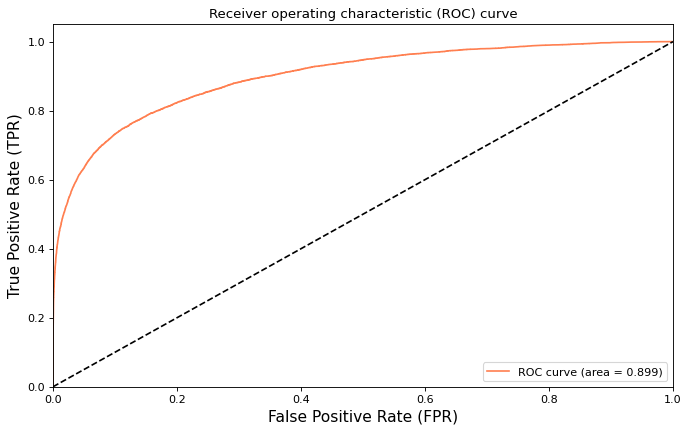

In [59]:
[fpr, tpr, thr] = roc_curve(y_train, pred_probs)

plt.figure(figsize=(10, 6), dpi=80)
plt.plot(fpr, tpr, color='coral', label='ROC curve (area = %0.3f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)', fontsize=14)
plt.ylabel('True Positive Rate (TPR)', fontsize=14)
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

In [65]:
from sklearn.metrics import confusion_matrix, accuracy_score
#print("accuracy: %2.3f" % accuracy_score(Y_train, pred_probs))
print("AUC: %2.3f" % auc(fpr, tpr))

AUC: 0.899


In [76]:
threshold = np.arange(0.1, 0.9, 0.1)
for i in threshold:
    train_survived_p = (pred_probs >= i).astype('int')
    c = confusion_matrix(Y_train, train_survived_p)
    accuracy = (c[0][0]+c[1][1])/84747
    
print(accuracy.max(),i)
    

0.9069701582356897 0.8


In [61]:

train_proba = pd.DataFrame({'Reorder_probability' : pred_probs})
train_proba

,Reorder_probability
0,0.030118
1,0.059194
2,0.197235
3,0.070454
4,0.056718
...,...
84742,0.033365
84743,0.076753
84744,0.089418
84745,0.049152


In [84]:
threshold_test = 0.8

test_reorder_label= (y_pred_prob >= threshold).astype('int')
reorder_table = pd.DataFrame({'test_reorder_label' : test_reorder_label,'test_reorder_probability' : y_pred_prob})
reorder_table.test_reorder_label.value_counts()

0    48167
1      166
Name: test_reorder_label, dtype: int64

In [85]:
reorder_table

,test_reorder_label,test_reorder_probability
0,0,0.029510
1,0,0.055158
2,0,0.257145
3,0,0.027191
4,0,0.047284
...,...,...
48328,0,0.045852
48329,0,0.083645
48330,0,0.064995
48331,0,0.022868


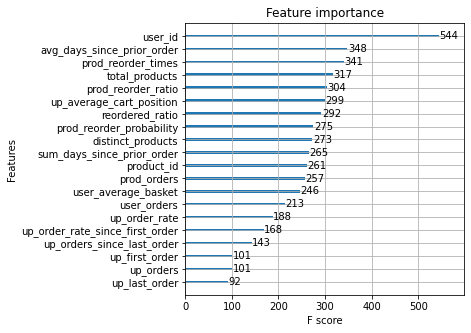

In [87]:
xgb.plot_importance(xgb_train)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()